In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Preprocessing
train_datagen = ImageDataGenerator(
#     horizontal_flip=True,
    rescale=1./255,
    validation_split = 0.15,
    rotation_range=20,          
    width_shift_range=0.1,     
    height_shift_range=0.1,     
#     shear_range=0.2,          
#     zoom_range=0.2,             
#     fill_mode='nearest'        
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_set = "/home/featurize/work/Compus_cars/train" 
# test_set = "C:/Users/dell/Desktop/Compus_cars/test"

2024-04-29 14:26:31.646285: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 14:26:33.046427: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
batch_size = 32
               
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    classes = ['MPV','sedan','hatchback','pickup','sports'],
    shuffle = True,
    seed=13,
    subset="training"
)

valid_generator = train_datagen.flow_from_directory(
    train_set,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    classes = ['MPV','sedan','hatchback','pickup','sports'],
    shuffle = False,
    seed=13,
    subset="validation"
)

Found 21540 images belonging to 5 classes.
Found 3798 images belonging to 5 classes.


In [3]:
classes = train_generator.class_indices
classes_index = dict((v,k) for k,v in classes.items())
img = train_generator.filepaths

# Get a batch from the generator
x_train, y_train = next(train_generator)
print(classes_index)
print(x_train.shape)
print(y_train.shape)

{0: 'MPV', 1: 'sedan', 2: 'hatchback', 3: 'pickup', 4: 'sports'}
(32, 224, 224, 3)
(32, 5)


In [4]:
classes = valid_generator.class_indices
classes_index = dict((v,k) for k,v in classes.items())
img = valid_generator.filepaths

# Get a batch from the generator
x_test, y_test = next(valid_generator)
print(classes_index)
print(x_test.shape)
print(y_test.shape)

{0: 'MPV', 1: 'sedan', 2: 'hatchback', 3: 'pickup', 4: 'sports'}
(32, 224, 224, 3)
(32, 5)


In [5]:
from PIL import Image

Image_path = img[0]
Image = Image.open(Image_path)
width,height = Image.size
channels = len(Image.getbands())
print(width,height,channels)

908 626 3


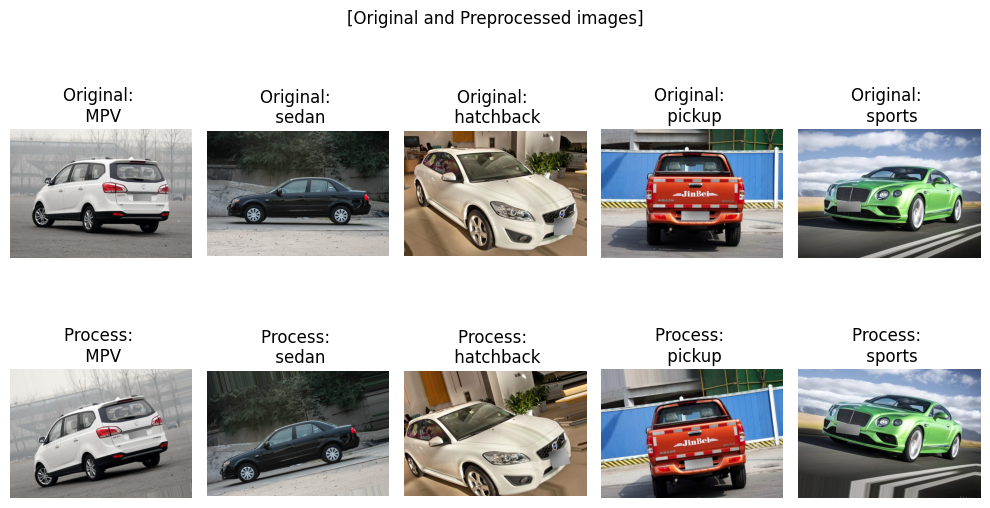

In [7]:
import os
import random
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, load_img

selected_images = []

for class_name in classes_index.values():
    class_path = os.path.join(train_set, str(class_name))
    random_image = random.choice(os.listdir(class_path))
    selected_images.append(os.path.join(class_path, random_image))

rows, cols = 2, len(classes)
fig, axs = plt.subplots(rows, cols, figsize=(10, 6))

for i, img_path in enumerate(selected_images, 1):
    class_name = os.path.basename(os.path.dirname(img_path))
    matching_keys = [str(key) for key in classes_index.keys() if str(key).lower() == str(class_name).lower()]
    
    # Load and preprocess the original image
    img_original = load_img(img_path)
    img_array_original = img_to_array(img_original)
    
    img_preprocessed = train_datagen.random_transform(img_array_original)
    
    plt.subplot(rows, cols, i)
    plt.imshow(image.array_to_img(img_array_original))
    plt.title(f"Original: \n {class_name}")
    plt.axis('off')
    
    plt.subplot(rows, cols, i + cols)
    plt.imshow(image.array_to_img(img_preprocessed))
    plt.title(f"Process: \n {class_name}")
    plt.axis('off')

fig.suptitle('[Original and Preprocessed images]')
plt.tight_layout()
plt.show()

In [6]:
from tensorflow.keras import layers, models

class ChannelAttention(layers.Layer):
    def __init__(self, channel, reduction=4):
        super(ChannelAttention, self).__init__()
        self.avg_pool = layers.GlobalAveragePooling2D()
        self.max_pool = layers.GlobalMaxPooling2D()
        self.fc = self.build_fc(channel,reduction)
        self.softmax = layers.Activation('softmax')
        
    def build_fc(self, channel, reduction):
        input_tensor = layers.Input(shape=(channel,))
        x = layers.Dense(channel * reduction, use_bias=False)(input_tensor)
        x = layers.ReLU()(x)
        x = layers.Dense(channel, use_bias=False)(x)
        return models.Model(inputs=input_tensor, outputs=x)

    def call(self, x):
        y1 = self.avg_pool(x)
        y1 = tf.expand_dims(tf.expand_dims(self.fc(y1), 1), 1)

        y2 = self.max_pool(x)
        y2 = tf.expand_dims(tf.expand_dims(self.fc(y2), 1), 1)

        y = self.softmax(y1 + y2)
        return x + x * y

class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=3):
        super(SpatialAttention, self).__init__()
        assert kernel_size % 2 == 1, "kernel_size = {}".format(kernel_size)
        padding = (kernel_size - 1) // 2
        self.conv = layers.Conv2D(1, kernel_size=kernel_size, padding='same', activation='softmax')

    def call(self, x):
        mask = self.conv(x)
        return x + x * mask

In [7]:
from keras import backend as K

def accuracy(y_true, y_pred):
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1)
    correct_predictions = K.equal(y_true, y_pred)
    return K.mean(K.cast(correct_predictions, K.floatx()))

In [10]:
# def weighted_categorical_crossentropy(y_true, y_pred, class_weights):
#     # Use logits (before softmax activation) for numerical stability
#     y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
#     logits = K.log(y_pred)
    
#     # Weighted categorical crossentropy formula
#     weighted_ce = tf.nn.weighted_cross_entropy_with_logits(labels=y_true, logits=logits, pos_weight=class_weights)
    
#     return K.mean(weighted_ce, axis=-1)

# def weighted_categorical_crossentropy(y_true, y_pred, weights):
#     # Convert weights to tensor
#     weights_tensor = tf.convert_to_tensor(weights, dtype=tf.float32)
#     # Apply weights to the cross-entropy loss
#     weighted_losses = tf.nn.weighted_cross_entropy_with_logits(labels=y_true, logits=y_pred, pos_weight=weights_tensor)
#     # Take the mean over all examples
#     loss = tf.reduce_mean(weighted_losses)
#     return loss

# Wavelet Transform

In [8]:
def WaveletTransformAxisY(batch_img):
    odd_img = batch_img[:, 0::2]
    even_img = batch_img[:, 1::2]
    L = (odd_img + even_img) / 2.0
    H = K.abs(odd_img - even_img)
    return L, H

def WaveletTransformAxisX(batch_img):
    # transpose + fliplr
    tmp_batch = K.permute_dimensions(batch_img, [0, 2, 1])[:, :, ::-1]
    _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
    # transpose + flipud
    dst_L = K.permute_dimensions(_dst_L, [0, 2, 1])[:, ::-1, ...]
    dst_H = K.permute_dimensions(_dst_H, [0, 2, 1])[:, ::-1, ...]
    return dst_L, dst_H

def wavelet_transform(img):
    wavelet_L, wavelet_H = WaveletTransformAxisY(img)
    wavelet_LL, wavelet_LH = WaveletTransformAxisX(wavelet_L)
    wavelet_HL, wavelet_HH = WaveletTransformAxisX(wavelet_H)
    return wavelet_LL, wavelet_LH, wavelet_HL, wavelet_HH

def Wavelet(batch_image, n=4):
    # make channel first image
    batch_image = K.permute_dimensions(batch_image, [0, 3, 1, 2])
    r = batch_image[:, 0]
    g = batch_image[:, 1]
    b = batch_image[:, 2]

    wavelet_levels = []
    for i in range(n):  # 4 levels of decomposition
        r_wavelets = wavelet_transform(r)
        g_wavelets = wavelet_transform(g)
        b_wavelets = wavelet_transform(b)

        wavelet_data = list(r_wavelets) + list(g_wavelets) + list(b_wavelets)
        wavelet_level = K.stack(wavelet_data, axis=1)
        wavelet_levels.append(K.permute_dimensions(wavelet_level, [0, 2, 3, 1]))

        r, g, b = r_wavelets[0], g_wavelets[0], b_wavelets[0]  # LL for next level
    return wavelet_levels

def Wavelet_out_shape(input_shapes):
    return [tuple([None, base_size // (2**i), base_size // (2**i), 12]) for i in range(4)]

In [12]:
def WaveletTransformAxisY(batch_img):
    # 适用向下取整以处理299x299的图像尺寸
    height = batch_img.shape[1] // 2 * 2
    odd_img = batch_img[:, :height:2]
    even_img = batch_img[:, 1:height:2]
    L = (odd_img + even_img) / 2.0
    H = K.abs(odd_img - even_img)
    return L, H

def WaveletTransformAxisX(batch_img):
    # transpose + fliplr
    width = batch_img.shape[2] // 2 * 2
    tmp_batch = K.permute_dimensions(batch_img[:, :, :width], [0, 2, 1])[:, :, ::-1]
    _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
    # transpose + flipud
    dst_L = K.permute_dimensions(_dst_L, [0, 2, 1])[:, ::-1, ...]
    dst_H = K.permute_dimensions(_dst_H, [0, 2, 1])[:, ::-1, ...]
    return dst_L, dst_H

def wavelet_transform(img):
    # 逐轴执行小波变换，并且处理图像尺寸减半的情况
    wavelet_L, wavelet_H = WaveletTransformAxisY(img)
    wavelet_LL, wavelet_LH = WaveletTransformAxisX(wavelet_L)
    wavelet_HL, wavelet_HH = WaveletTransformAxisX(wavelet_H)
    return wavelet_LL, wavelet_LH, wavelet_HL, wavelet_HH

def Wavelet(batch_image, n=4):
    # make channel first image
    batch_image = K.permute_dimensions(batch_image, [0, 3, 1, 2])
    r = batch_image[:, 0]
    g = batch_image[:, 1]
    b = batch_image[:, 2]

    wavelet_levels = []
    for i in range(n):  # 4 levels of decomposition
        r_wavelets = wavelet_transform(r)
        g_wavelets = wavelet_transform(g)
        b_wavelets = wavelet_transform(b)

        wavelet_data = list(r_wavelets) + list(g_wavelets) + list(b_wavelets)
        wavelet_level = K.stack(wavelet_data, axis=1)
        wavelet_levels.append(K.permute_dimensions(wavelet_level, [0, 2, 3, 1]))

        r, g, b = r_wavelets[0], g_wavelets[0], b_wavelets[0]  # LL for next level

    return wavelet_levels

def Wavelet_out_shape(input_shapes):
    base_size = 299
    return [tuple([None, base_size // (2**i), base_size // (2**i), 12]) for i in range(4)]

# DWAN model

In [9]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Reshape, concatenate
from keras.layers import Lambda
from keras.initializers import he_normal
from keras import regularizers
from tensorflow.keras.models import Model
import tensorflow as tf

def build_domain_classifier(input_shape):
    input_ = Input(input_shape)
    dense1 = Dense(64, activation='relu')(input_)
    dense2 = Dense(32, activation='relu')(dense1)
    output = Dense(1, activation='sigmoid')(dense2)  
    model = Model(inputs=input_, outputs=output)
    return model

def build_branch(input_tensor, filters, reduction=16):
    branch = Conv2D(filters[0]//2, kernel_size=3, activation='relu',padding='same', kernel_initializer=he_normal())(input_tensor)
    branch = BatchNormalization()(branch)
    branch = Conv2D(filters[1]//2, kernel_size=1, activation='relu',padding='same',kernel_initializer=he_normal())(branch)
    branch = ChannelAttention(filters[1]//2, reduction=reduction)(branch)
    branch = MaxPooling2D(pool_size=2, strides=2)(branch)
    branch = Dropout(0.2)(branch)
    return branch

def DWAN(num_classes, reduction=16, spatial_kernel_size=3):
    input_shape = (224, 224, 3)
    input_ = Input(input_shape, name='input')
    wavelet = Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3, input_l4 = wavelet(input_)

    branch1 = build_branch(input_l1, [16, 32, 32], reduction=reduction)
    branch2 = build_branch(input_l2, [16, 32, 32], reduction=reduction)
    branch3 = build_branch(input_l3, [16, 32, 32], reduction=reduction)
    branch4 = build_branch(input_l4, [16, 32, 32], reduction=reduction)
    
    conv_a = Conv2D(32, kernel_size=3, strides=(2, 2),activation='relu',padding='same',name='conv_1', kernel_initializer=he_normal())(branch1)
    concat_branches1_2 = concatenate([conv_a, branch2])
    concat_branches = SpatialAttention(kernel_size=spatial_kernel_size)(concat_branches1_2)
    
    conv_b = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2', activation='relu', kernel_initializer=he_normal())(concat_branches1_2)
    concat_branches1_2_3 = concatenate([conv_b, branch3])
    concat_branches = SpatialAttention(kernel_size=spatial_kernel_size)(concat_branches1_2_3)
    
    conv_c = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2_3', activation='relu', kernel_initializer=he_normal())(concat_branches1_2_3)
    concat_branches1_2_3_4 = concatenate([conv_c, branch4])
    concat_branches = SpatialAttention(kernel_size=spatial_kernel_size)(concat_branches1_2_3_4)

    common_conv = Conv2D(32, kernel_size=3, activation='relu')(concat_branches)
    common_norm = BatchNormalization()(common_conv)

    global_avg_pooling = GlobalAveragePooling2D()(common_norm)
    dense1 = Dense(32, activation='relu',
                   kernel_initializer=he_normal(), 
                   kernel_regularizer=regularizers.l2(0.01))(global_avg_pooling)
    dropout = Dropout(0.2)(dense1)

    output = Dense(num_classes, activation='softmax')(dropout)

    domain_classifier = build_domain_classifier(global_avg_pooling.shape[1:])(global_avg_pooling)
    model = Model(inputs=input_, outputs=[output, domain_classifier])  
    return model

DWAN_model = DWAN(num_classes=5)

DWAN_model.summary()

2024-04-29 14:27:32.323545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-29 14:27:32.364261: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-29 14:27:32.364517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 wavelet (Lambda)            [(None, 112, 112, 12),       0         ['input[0][0]']               
                              (None, 56, 56, 12),                                                 
                              (None, 28, 28, 12),                                                 
                              (None, 14, 14, 12)]                                                 
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 8)          872       ['wavelet[0][0]']       

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy

DWAN_model.compile(optimizer=Adam(learning_rate=lr),
                   loss=[weighted_categorical_crossentropy, binary_crossentropy],
                   metrics=[CategoricalAccuracy(), BinaryAccuracy()])

def compute_class_weights(labels):
    class_weights = {}
    total_samples = len(labels)
    unique_labels = np.unique(labels)
    for label in unique_labels:
        class_count = np.sum(labels == label)
        class_weights[label] = total_samples / (len(unique_labels) * class_count)
    return class_weights

train_class_weights = compute_class_weights(train_generator.labels)

def total_loss(y_true, y_pred):
    class_loss = weighted_categorical_crossentropy(y_true[0], y_pred[0], train_class_weights)
    domain_loss = binary_crossentropy(y_true[1], y_pred[1])
    total_loss = class_loss + domain_loss
    return total_loss

history = DWAN_model.fit(train_generator,
                         steps_per_epoch=len(train_generator),
                         epochs=40,
                         validation_data=test_generator,
                         validation_steps=len(test_generator))

losses_and_metrics = DWAN_model.evaluate(test_generator)
print("Domain Classification Accuracy:", losses_and_metrics[3])
print("Label Classification Accuracy:", losses_and_metrics[4])
print("Total Loss:", losses_and_metrics[0])

In [19]:
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import itertools

plt.rcParams['figure.dpi'] = 150
figure_size = [224, 288, 352, 416]
drop_out = [0.2, 0.3, 0.4, 0.5]
learning_rate = [0.001, 0.0005, 0.0001]
all_train, all_val = list(), list()

for param1, param2, param3 in itertools.product(figure_size, drop_out, learning_rate):
    batch_size = 128
               
    train_generator = train_datagen.flow_from_directory(
        train_set,
        target_size=(param1, param1),
        batch_size=batch_size,
        class_mode='categorical',
        classes = ['MPV','sedan','hatchback','pickup','sports'],
        shuffle = True,
        seed=13,
        subset="training"
    )

    valid_generator = train_datagen.flow_from_directory(
        train_set,
        target_size=(param1, param1),
        batch_size=batch_size,
        class_mode='categorical',
        classes = ['MPV','sedan','hatchback','pickup','sports'],
        shuffle = False,
        seed=13,
        subset="validation"
    )

    # Get a batch from the generator
    x_train, y_train = next(train_generator)
    x_val, y_val = next(valid_generator)
    
    def WaveletTransformAxisY(batch_img):
        odd_img = batch_img[:, 0::2]
        even_img = batch_img[:, 1::2]
        L = (odd_img + even_img) / 2.0
        H = K.abs(odd_img - even_img)
        return L, H

    def WaveletTransformAxisX(batch_img):
        # transpose + fliplr
        tmp_batch = K.permute_dimensions(batch_img, [0, 2, 1])[:, :, ::-1]
        _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
        # transpose + flipud
        dst_L = K.permute_dimensions(_dst_L, [0, 2, 1])[:, ::-1, ...]
        dst_H = K.permute_dimensions(_dst_H, [0, 2, 1])[:, ::-1, ...]
        return dst_L, dst_H

    def wavelet_transform(img):
        wavelet_L, wavelet_H = WaveletTransformAxisY(img)
        wavelet_LL, wavelet_LH = WaveletTransformAxisX(wavelet_L)
        wavelet_HL, wavelet_HH = WaveletTransformAxisX(wavelet_H)
        return wavelet_LL, wavelet_LH, wavelet_HL, wavelet_HH

    def Wavelet(batch_image, n=4):
        # make channel first image
        batch_image = K.permute_dimensions(batch_image, [0, 3, 1, 2])
        r = batch_image[:, 0]
        g = batch_image[:, 1]
        b = batch_image[:, 2]

        wavelet_levels = []
        for i in range(n):  # 4 levels of decomposition
            r_wavelets = wavelet_transform(r)
            g_wavelets = wavelet_transform(g)
            b_wavelets = wavelet_transform(b)

            wavelet_data = list(r_wavelets) + list(g_wavelets) + list(b_wavelets)
            wavelet_level = K.stack(wavelet_data, axis=1)
            wavelet_levels.append(K.permute_dimensions(wavelet_level, [0, 2, 3, 1]))

            r, g, b = r_wavelets[0], g_wavelets[0], b_wavelets[0]  # LL for next level
        return wavelet_levels

    def Wavelet_out_shape(input_shapes):
        return [tuple([None, param1 // (2**i), param1 // (2**i), 12]) for i in range(4)]

    image_size = param1
    def build_branch(input_tensor, filters, reduction=4):
        r = layers.Conv2D(filters[1], kernel_size=1, activation='relu', padding='same')(input_tensor)
        branch = layers.Conv2D(filters[0], kernel_size=(3, 3), activation='relu', padding='same')(input_tensor)
        branch = layers.BatchNormalization()(branch)
        branch = layers.Conv2D(filters[1], kernel_size=1, activation='relu', padding='same')(branch)
        branch = r + layers.BatchNormalization()(branch)
        branch = ChannelAttention(filters[2], reduction=reduction)(branch)
        branch = Dropout(param2)(branch)
        return branch

    def Res_DWAN(num_classes, reduction=4, spatial_kernel_size=3):
        input_shape = (image_size, image_size, 3)
        input_ = layers.Input(input_shape, name='input')
        wavelet = layers.Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
        input_l1, input_l2, input_l3, input_l4 = wavelet(input_)

        branch1 = build_branch(input_l1, [32, 64, 64], reduction=reduction)
        branch2 = build_branch(input_l2, [64, 128, 128], reduction=reduction)
        branch3 = build_branch(input_l3, [128, 256, 256], reduction=reduction)
        branch4 = build_branch(input_l4, [128, 256, 256], reduction=reduction)

        conv_a = layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same', name='conv_1',
                           kernel_initializer=he_normal())(branch1)
        norm_a = layers.BatchNormalization()(conv_a)
        concat_branches1_2 = layers.concatenate([norm_a, branch2])

        conv_b = layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2', activation='relu',
                           kernel_initializer=he_normal())(concat_branches1_2)
        norm_b = layers.BatchNormalization()(conv_b)
        concat_branches1_2_3 = layers.concatenate([norm_b, branch3])

        conv_c = layers.Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2_3', activation='relu',
                           kernel_initializer=he_normal())(concat_branches1_2_3)
        norm_c = layers.BatchNormalization()(conv_c)
        concat_branches1_2_3_4 = layers.concatenate([norm_c, branch4])

        common_conv = layers.Conv2D(256, kernel_size=3, activation='relu', kernel_initializer=he_normal())(
        concat_branches1_2_3_4)
        common_norm = layers.BatchNormalization()(common_conv)

        spatial = SpatialAttention(kernel_size=spatial_kernel_size)(common_norm)
        global_avg_pooling = layers.GlobalAveragePooling2D()(spatial)
        
        output = layers.Dense(num_classes, activation='softmax')(global_avg_pooling)
        
        model = models.Model(inputs=input_, outputs=output)
        return model
    
        classWeight= [0.84, 0.83, 2.37, 1.01, 0.84]
        Res_DWAN = Res_DWAN(num_classes=5)
        Res_DWAN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=param3), loss='categorical_crossentropy', metrics=['accuracy'])
        Res_DWAN.fit(train_generator, 
                     steps_per_epoch=len(train_generator), 
                     epochs=30, 
                     validation_data=valid_generator,
                     validation_steps=len(valid_generator),
                     classWeights = classWeight,
                     verbose=0)
    
        _, train_acc = Res_DWAN.evaluate(x_train, y_train, verbose=0)
        _, val_acc = Res_DWAN.evaluate(x_val, y_val, verbose=0)
    
        print('Param: %f, Train: %.3f, Validation: %.3f' % (param, train_acc, val_acc))
        all_train.append(train_acc)
        all_val.append(val_acc)

Found 21540 images belonging to 5 classes.
Found 3798 images belonging to 5 classes.
Found 21540 images belonging to 5 classes.
Found 3798 images belonging to 5 classes.
Found 21540 images belonging to 5 classes.
Found 3798 images belonging to 5 classes.
Found 21540 images belonging to 5 classes.
Found 3798 images belonging to 5 classes.
Found 21540 images belonging to 5 classes.
Found 3798 images belonging to 5 classes.
Found 21540 images belonging to 5 classes.
Found 3798 images belonging to 5 classes.
Found 21540 images belonging to 5 classes.
Found 3798 images belonging to 5 classes.
Found 21540 images belonging to 5 classes.
Found 3798 images belonging to 5 classes.
Found 21540 images belonging to 5 classes.
Found 3798 images belonging to 5 classes.
Found 21540 images belonging to 5 classes.
Found 3798 images belonging to 5 classes.
Found 21540 images belonging to 5 classes.
Found 3798 images belonging to 5 classes.
Found 21540 images belonging to 5 classes.
Found 3798 images belo

KeyboardInterrupt: 

# Base Model

In [14]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Reshape, concatenate
from keras.layers import Lambda
from keras.initializers import he_normal
from keras import regularizers
from tensorflow.keras.models import Model
import tensorflow as tf

def build_branch(input_tensor, filters, reduction=16,spatial_kernel_size=3):
    branch = Conv2D(filters[0]//2, kernel_size=(3, 3), activation='relu',padding='same')(input_tensor)
    branch = BatchNormalization()(branch)
    branch = Conv2D(filters[1]//2, kernel_size=1, activation='relu',padding='same')(branch)
    branch = ChannelAttention(filters[1]//2, reduction=reduction)(branch)
    branch = MaxPooling2D(pool_size=2, strides=2)(branch)
    branch = Dropout(0.2)(branch)
    return branch

def DWAN(num_classes, reduction=16, spatial_kernel_size=3):
    input_shape = (224, 224, 3)
    input_ = Input(input_shape, name='input')
    wavelet = Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3, input_l4 = wavelet(input_)

    branch1 = build_branch(input_l1, [16,32,32], reduction=reduction)
    branch2 = build_branch(input_l2, [16,32,32], reduction=reduction)
    branch3 = build_branch(input_l3, [16,32,32], reduction=reduction)
    branch4 = build_branch(input_l4, [16,32,32], reduction=reduction)
    
    conv_a = Conv2D(32, kernel_size=(3, 3), strides=(2, 2),activation='relu',padding='same',name='conv_1', kernel_initializer=he_normal())(branch1)
    norm_a = BatchNormalization()(conv_a)
    concat_branches1_2 = concatenate([norm_a, branch2])
    
    conv_b = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2', activation='relu', kernel_initializer=he_normal())(concat_branches1_2)
    norm_b = BatchNormalization()(conv_b)
    concat_branches1_2_3 = concatenate([norm_b, branch3])
    
    conv_c = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2_3', activation='relu', kernel_initializer=he_normal())(concat_branches1_2_3)
    norm_c = BatchNormalization()(conv_c)
    concat_branches1_2_3_4 = concatenate([norm_c, branch4])

    common_conv = Conv2D(64, kernel_size=3, activation='relu', kernel_initializer=he_normal())(concat_branches1_2_3_4)
    common_norm = BatchNormalization()(common_conv)
    
    spatial = SpatialAttention(kernel_size=spatial_kernel_size)(common_conv)

    global_avg_pooling = GlobalAveragePooling2D()(spatial)
    
    dense1 = Dense(64, activation='relu',
                   kernel_initializer=he_normal(), 
                   kernel_regularizer=regularizers.l2(0.01))(global_avg_pooling)
    
    dropout1 = Dropout(0.2)(dense1)

    output = Dense(num_classes, activation='softmax')(dropout1)

    model = Model(inputs=input_, outputs=output)  
    return model

DWAN_model = DWAN(num_classes=5)

DWAN_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 wavelet (Lambda)            [(None, 112, 112, 12),       0         ['input[0][0]']               
                              (None, 56, 56, 12),                                                 
                              (None, 28, 28, 12),                                                 
                              (None, 14, 14, 12)]                                                 
                                                                                                  
 conv2d_12 (Conv2D)          (None, 112, 112, 8)          872       ['wavelet[0][0]']      

# Res-DWAN

In [10]:
image_size = 224
def build_branch(input_tensor, filters, reduction=4):
    r = layers.Conv2D(filters[1], kernel_size=1, activation='relu', padding='same')(input_tensor)
    branch = layers.Conv2D(filters[0], kernel_size=(3, 3), activation='relu', padding='same')(input_tensor)
    branch = layers.BatchNormalization()(branch)
    branch = layers.Conv2D(filters[1], kernel_size=1, activation='relu', padding='same')(branch)
    branch = r + layers.BatchNormalization()(branch)
    branch = ChannelAttention(filters[2], reduction=reduction)(branch)
    branch = Dropout(0.2)(branch)
    return branch


def Res_DWAN(num_classes, reduction=4, spatial_kernel_size=3):
    input_shape = (image_size, image_size, 3)
    input_ = layers.Input(input_shape, name='input')
    wavelet = layers.Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3, input_l4 = wavelet(input_)

    branch1 = build_branch(input_l1, [32, 64, 64], reduction=reduction)
    branch2 = build_branch(input_l2, [64, 128, 128], reduction=reduction)
    branch3 = build_branch(input_l3, [128, 256, 256], reduction=reduction)
    branch4 = build_branch(input_l4, [128, 256, 256], reduction=reduction)

    conv_a = layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same', name='conv_1',
                           kernel_initializer=he_normal())(branch1)
    norm_a = layers.BatchNormalization()(conv_a)
    concat_branches1_2 = layers.concatenate([norm_a, branch2])

    conv_b = layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2', activation='relu',
                           kernel_initializer=he_normal())(concat_branches1_2)
    norm_b = layers.BatchNormalization()(conv_b)
    concat_branches1_2_3 = layers.concatenate([norm_b, branch3])

    conv_c = layers.Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2_3', activation='relu',
                           kernel_initializer=he_normal())(concat_branches1_2_3)
    norm_c = layers.BatchNormalization()(conv_c)
    concat_branches1_2_3_4 = layers.concatenate([norm_c, branch4])

    common_conv = layers.Conv2D(256, kernel_size=3, activation='relu', kernel_initializer=he_normal())(
        concat_branches1_2_3_4)
    common_norm = layers.BatchNormalization()(common_conv)

    spatial = SpatialAttention(kernel_size=spatial_kernel_size)(common_norm)

    global_avg_pooling = layers.GlobalAveragePooling2D()(spatial)

    output = layers.Dense(num_classes, activation='softmax')(global_avg_pooling)

    model = models.Model(inputs=input_, outputs=output)
    return model


Res_DWAN = Res_DWAN(num_classes=5)


# Inception-DWAN

In [ ]:
image_size = 224
def build_branch(input_tensor, filters, reduction=4):
    r = layers.Conv2D(filters[1], kernel_size=1, activation='relu', padding='same')(input_tensor)
    branch = layers.Conv2D(filters[0], kernel_size=(3, 3), activation='relu', padding='same')(input_tensor)
    branch = layers.BatchNormalization()(branch)
    branch = layers.Conv2D(filters[1], kernel_size=1, activation='relu', padding='same')(branch)
    branch = r + layers.BatchNormalization()(branch)
    branch = ChannelAttention(filters[2], reduction=reduction)(branch)
    branch = Dropout(0.2)(branch)
    return branch

def build_Block_A(input_l,filters_branch1,filters_branch2,filters_branch3,filters_branch4,filters_a,filters_b,filters_c,filters_com,reduction=4):
    branch1 = build_branch(input_l[0], filters_branch1, reduction=reduction)
    branch2 = build_branch(input_l[1], filters_branch2, reduction=reduction)
    branch3 = build_branch(input_l[2], filters_branch3, reduction=reduction)
    branch4 = build_branch(input_l[3], filters_branch4, reduction=reduction)

    conv_a = layers.Conv2D(filters_a, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same', name='conv_1',
                           kernel_initializer=he_normal())(branch1)
    norm_a = layers.BatchNormalization()(conv_a)
    concat_branches1_2 = layers.concatenate([norm_a, branch2])

    conv_b = layers.Conv2D(filters_b, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2', activation='relu',
                           kernel_initializer=he_normal())(concat_branches1_2)
    norm_b = layers.BatchNormalization()(conv_b)
    concat_branches1_2_3 = layers.concatenate([norm_b, branch3])

    conv_c = layers.Conv2D(filters_c, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2_3', activation='relu',
                           kernel_initializer=he_normal())(concat_branches1_2_3)
    norm_c = layers.BatchNormalization()(conv_c)
    concat_branches1_2_3_4 = layers.concatenate([norm_c, branch4])

    common_conv = layers.Conv2D(filters_com, kernel_size=3, activation='relu', kernel_initializer=he_normal())(
        concat_branches1_2_3_4)
    common_norm = layers.BatchNormalization()(common_conv)
    return common_norm

def build_Block_B(input_l,filters_a,filters_b,filters_c,filters_d):
    branch1 = input_l[0]
    branch2 = input_l[1]
    branch3 = input_l[2]
    branch4 = input_l[3]

    conv_a = layers.Conv2D(filters_a, kernel_size=(1, 1), kernel_initializer=he_normal())(branch1)
    norm_a = layers.BatchNormalization()(conv_a)
    relu_a = layers.Activation('relu')(norm_a)

    conv_b = layers.Conv2D(filters_b, kernel_size=(1, 1), kernel_initializer=he_normal())(branch2)
    norm_b = layers.BatchNormalization()(conv_b)
    relu_b = layers.Activation('relu')(norm_b)
    conv_b_1 = layers.Conv2D(filters_b, kernel_size=(3, 3),padding='same', kernel_initializer=he_normal())(relu_b)
    norm_b_1 = layers.BatchNormalization()(conv_b_1)
    relu_b_1 = layers.Activation('relu')(norm_b_1)

    conv_c = layers.Conv2D(filters_c, kernel_size=(1, 1), kernel_initializer=he_normal())(branch3)
    norm_c = layers.BatchNormalization()(conv_c)
    relu_c = layers.Activation('relu')(norm_c)
    conv_c_1 = layers.Conv2D(filters_c, kernel_size=(5, 5),padding='same', kernel_initializer=he_normal())(relu_c)
    norm_c_1 = layers.BatchNormalization()(conv_c_1)
    relu_c_1 = layers.Activation('relu')(norm_c_1)

    max_d =  layers.MaxPooling2D(pool_size=3, strides=1,padding='same')(branch4)
    conv_d = layers.Conv2D(filters_d, kernel_size=1, kernel_initializer=he_normal())(max_d)
    norm_d = layers.BatchNormalization()(conv_d)
    relu_d = layers.Activation('relu')(norm_d)
    
    concat_branches1_2_3_4 = layers.concatenate([relu_a, relu_b_1, relu_c_1, relu_d])
    return concat_branches1_2_3_4


def Inception_DWAN(num_classes, reduction=4, spatial_kernel_size=3):
    input_shape = (image_size, image_size, 3)
    input_ = layers.Input(input_shape, name='input')
    wavelet = layers.Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3, input_l4 = wavelet(input_)
    
    Block1 = build_Block_A([input_l1, input_l2, input_l3, input_l4],[16,32,32],[16,32,32],[16,32,32],[16,32,32],32 ,32 ,32 ,32 )
    Block2 = build_Block_B([Block1, Block1, Block1, Block1],64 ,64 ,64 ,64)
    Block3 = build_Block_B([Block2, Block2, Block2, Block2],128 ,128 ,128 ,128 )
    Block4 = build_Block_B([Block3, Block3, Block3, Block3],256 ,256 ,256 ,256 )
    
    spatial = SpatialAttention(kernel_size=spatial_kernel_size)(Block4)

    global_avg_pooling = layers.GlobalAveragePooling2D()(spatial)

    output = layers.Dense(num_classes, activation='softmax')(global_avg_pooling)

    model = models.Model(inputs=input_, outputs=output)
    return model


Inception_DWAN = Inception_DWAN(num_classes=5)

In [ ]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout,BatchNormalization,Activation
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, Concatenate, Lambda,GlobalAveragePooling2D
from tensorflow.keras import backend as K

def conv2d_bn(x,filters,kernel_size,strides=1,padding='same',activation='relu',use_bias=False,name=None):
    
    x = Conv2D(filters,kernel_size,strides=strides,padding=padding,use_bias=use_bias,name=name)(x)
    
    if not use_bias:
        bn_axis = 1 if K.image_data_format() == 'channels_first' else 3
        bn_name = None if name is None else name + '_bn'
        x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    if activation is not None:
        ac_name = None if name is None else name + '_ac'
        x = Activation(activation, name=ac_name)(x)
    return x

def inception_resnet_block(x, scale, block_type, block_idx, activation='relu'):
    if block_type == 'block35':
        branch_0 = conv2d_bn(x, 32, 1)
        branch_1 = conv2d_bn(x, 32, 1)
        branch_1 = conv2d_bn(branch_1, 32, 3)
        branch_2 = conv2d_bn(x, 32, 1)
        branch_2 = conv2d_bn(branch_2, 48, 3)
        branch_2 = conv2d_bn(branch_2, 64, 3)
        branches = [branch_0, branch_1, branch_2]
    elif block_type == 'block17':
        branch_0 = conv2d_bn(x, 192, 1)
        branch_1 = conv2d_bn(x, 128, 1)
        branch_1 = conv2d_bn(branch_1, 160, [1, 7])
        branch_1 = conv2d_bn(branch_1, 192, [7, 1])
        branches = [branch_0, branch_1]
    elif block_type == 'block8':
        branch_0 = conv2d_bn(x, 192, 1)
        branch_1 = conv2d_bn(x, 192, 1)
        branch_1 = conv2d_bn(branch_1, 224, [1, 3])
        branch_1 = conv2d_bn(branch_1, 256, [3, 1])
        branches = [branch_0, branch_1]
    else:
        raise ValueError('Unknown Inception-ResNet block type. '
                         'Expects "block35", "block17" or "block8", '
                         'but got: ' + str(block_type))

    block_name = block_type + '_' + str(block_idx)
    mixed = Concatenate(name=block_name + '_mixed')(branches)
    up = conv2d_bn(mixed,K.int_shape(x)[3],1,activation=None,use_bias=True,name=block_name + '_conv')

    x = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
               output_shape=K.int_shape(x)[1:],
               arguments={'scale': scale},
               name=block_name)([x, up])
    if activation is not None:
        x = Activation(activation, name=block_name + '_ac')(x)
    return x

def stem(inputs, reduction=4):
    x = conv2d_bn(inputs, 32, 3, strides=2, padding='valid')
    x = conv2d_bn(x, 32, 3, padding='valid')
    x = conv2d_bn(x, 64, 3)
    x = MaxPooling2D(3, strides=2, padding='valid')(x)
    x = conv2d_bn(x, 80, 1)
    # x = conv2d_bn(x, 192, 3, padding='valid')
    # x = conv2d_bn(x, 256, 3, strides=2, padding='valid')
    x =  ChannelAttention(80, reduction=reduction)(x)
    return x
    
    
def Inception_ResNet(input_shape=[299,299,3],classes=5):

    inputs = Input(shape=input_shape)
    wavelet = layers.Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3, input_l4 = wavelet(inputs)
    
    L1 = stem(input_l1)
    L2 = stem(input_l2)
    L3 = stem(input_l3)
    L4 = stem(input_l4)

    # Mixed 5b (Inception-A block)
    # branch_0 = conv2d_bn(L4, 32, 1)
    # branch_1 = conv2d_bn(L3, 32, 1)
    # branch_1 = conv2d_bn(branch_1, 32, 3)
    # branch_2 = conv2d_bn(L2, 32, 1)
    # branch_2 = conv2d_bn(branch_2, 32, 3)
    # branch_2 = conv2d_bn(branch_2, 48, 3)
    # branch_3 = conv2d_bn(L1, 32, 1)
    # branch_3 = conv2d_bn(branch_3, 32, 3)
    # branch_3 = conv2d_bn(branch_3, 48, 3)
    # branch_3 = conv2d_bn(branch_3, 64, 3)
    branch1 = conv2d_bn(L1, 32, 3)
    branches1_2 = [branch1, L2]
    branches1_2 = Concatenate()(branches1_2)
    branch2 = conv2d_bn(branches1_2, 48, 3)
    branches1_2_3 = [branches2, L3]
    branches1_2_3 = Concatenate()(branches1_2_3)
    branch3 = conv2d_bn(branches1_2_3, 48, 3)
    branches1_2_3_4 = [branches3, L4]
    x = Concatenate()(branches1_2_3_4)

    for block_idx in range(1, 6):
        x = inception_resnet_block(x, scale=0.17, block_type='block35', block_idx=block_idx)

    # Reduction-A block
    branch_0 = conv2d_bn(x, 384, 3, strides=2, padding='valid')
    branch_1 = conv2d_bn(x, 256, 1)
    branch_1 = conv2d_bn(branch_1, 256, 3)
    branch_1 = conv2d_bn(branch_1, 384, 3, strides=2, padding='valid')
    branch_pool = MaxPooling2D(3, strides=2, padding='valid')(x)
    branches = [branch_0, branch_1, branch_pool]
    x = Concatenate(name='mixed_6a')(branches)

    for block_idx in range(1, 11):
        x = inception_resnet_block(x, scale=0.1, block_type='block17', block_idx=block_idx)


    # Reduction-B block
    branch_0 = conv2d_bn(x, 256, 1)
    branch_0 = conv2d_bn(branch_0, 384, 3, strides=2, padding='valid')
    branch_1 = conv2d_bn(x, 256, 1)
    branch_1 = conv2d_bn(branch_1, 288, 3, strides=2, padding='valid')
    branch_2 = conv2d_bn(x, 256, 1)
    branch_2 = conv2d_bn(branch_2, 288, 3)
    branch_2 = conv2d_bn(branch_2, 320, 3, strides=2, padding='valid')
    branch_pool = MaxPooling2D(3, strides=2, padding='valid')(x)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    x = Concatenate(name='mixed_7a')(branches)

    for block_idx in range(1, 6):
        x = inception_resnet_block(x, scale=0.2, block_type='block8', block_idx=block_idx)
    x = inception_resnet_block(x, scale=1., activation=None, block_type='block8', block_idx=5)

    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)

    # 创建模型
    model = Model(inputs, x, name='inception_resnet_v2')

    return model

model = Inception_ResNet([299,299,3],5)
model.summary()


In [ ]:
image_size = 224
def build_branch(input_tensor, filters, reduction=4):
    r = layers.Conv2D(filters[1], kernel_size=1, activation='relu', padding='same')(input_tensor)
    branch = layers.Conv2D(filters[0], kernel_size=(3, 3), activation='relu', padding='same')(input_tensor)
    branch = layers.BatchNormalization()(branch)
    branch = layers.Conv2D(filters[1], kernel_size=1, activation='relu', padding='same')(branch)
    branch = r + layers.BatchNormalization()(branch)
    branch = ChannelAttention(filters[2], reduction=reduction)(branch)
    branch = Dropout(0.2)(branch)
    return branch

def build_Block_A(input_l,filters_branch1,filters_branch2,filters_branch3,filters_a,filters_b,filters_c,filters_com,reduction=4):
    branch1 = build_branch(input_l[0], filters_branch1, reduction=reduction)
    branch2 = build_branch(input_l[1], filters_branch2, reduction=reduction)
    branch3 = build_branch(input_l[2], filters_branch3, reduction=reduction)

    conv_a = layers.Conv2D(filters_a, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same', name='conv_1',
                           kernel_initializer=he_normal())(branch1)
    norm_a = layers.BatchNormalization()(conv_a)
    concat_branches1_2 = layers.concatenate([norm_a, branch2])

    conv_b = layers.Conv2D(filters_b, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2', activation='relu',
                           kernel_initializer=he_normal())(concat_branches1_2)
    norm_b = layers.BatchNormalization()(conv_b)
    concat_branches1_2_3 = layers.concatenate([norm_b, branch3])

#     conv_c = layers.Conv2D(filters_c, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2_3', activation='relu',
#                            kernel_initializer=he_normal())(concat_branches1_2_3)
#     norm_c = layers.BatchNormalization()(conv_c)

#     common_conv = layers.Conv2D(filters_com, kernel_size=3, activation='relu', kernel_initializer=he_normal())(
#         norm_c)
#     common_norm = layers.BatchNormalization()(common_conv)
    return concat_branches1_2_3

def build_Block_B(input_l,filters_branch1,filters_branch2,filters_branch3,filters_branch4,filters_a,filters_b,filters_c,filters_d,reduction=4):
    branch1 = build_branch(input_l[0], filters_branch1, reduction=reduction)
    branch2 = build_branch(input_l[1], filters_branch2, reduction=reduction)
    branch3 = build_branch(input_l[2], filters_branch3, reduction=reduction)
    branch4 = build_branch(input_l[3], filters_branch4, reduction=reduction)

    conv_a = layers.Conv2D(filters_a, kernel_size=(1, 1), kernel_initializer=he_normal())(branch1)
    norm_a = layers.BatchNormalization()(conv_a)
    relu_a = layers.Activation('relu')(norm_a)

    conv_b = layers.Conv2D(filters_b, kernel_size=(1, 1), kernel_initializer=he_normal())(branch2)
    norm_b = layers.BatchNormalization()(conv_b)
    relu_b = layers.Activation('relu')(norm_b)
    conv_b_1 = layers.Conv2D(filters_b, kernel_size=(3, 3),padding='same', kernel_initializer=he_normal())(relu_b)
    norm_b_1 = layers.BatchNormalization()(conv_b_1)
    relu_b_1 = layers.Activation('relu')(norm_b_1)

    conv_c = layers.Conv2D(filters_c, kernel_size=(1, 1), kernel_initializer=he_normal())(branch3)
    norm_c = layers.BatchNormalization()(conv_c)
    relu_c = layers.Activation('relu')(norm_c)
    conv_c_1 = layers.Conv2D(filters_c, kernel_size=(5, 5),padding='same', kernel_initializer=he_normal())(relu_c)
    norm_c_1 = layers.BatchNormalization()(conv_c_1)
    relu_c_1 = layers.Activation('relu')(norm_c_1)

    max_d =  layers.MaxPooling2D(pool_size=3, strides=1,padding='same')(branch4)
    conv_d = layers.Conv2D(filters_d, kernel_size=1, kernel_initializer=he_normal())(max_d)
    norm_d = layers.BatchNormalization()(conv_d)
    relu_d = layers.Activation('relu')(norm_d)
    
    concat_branches1_2_3_4 = layers.concatenate([relu_a, relu_b, relu_c, relu_d])
    return concat_branches1_2_3_4


def Inception_DWAN_3L(num_classes, reduction=4, spatial_kernel_size=3):
    input_shape = (image_size, image_size, 3)
    input_ = layers.Input(input_shape, name='input')
    wavelet = layers.Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3= wavelet(input_)
    
    Block1 = build_Block_A([input_l1, input_l2, input_l3],[16,32,32],[16,32,32],[16,32,32],32 ,32 ,32 ,32 )
    Block2 = build_Block_B([Block1,Block1,Block1,Block1],[32,64,64],[32,64,64],[32,64,64],[32,64,64],64 ,64 ,64 ,64 )
    Block3 = build_Block_B([Block2,Block2,Block2,Block2],[64,128,128],[64,128,128],[64,128,128],[64,128,128],128 ,128 ,128 ,128 )
    
    spatial = SpatialAttention(kernel_size=spatial_kernel_size)(Block3)

    global_avg_pooling = layers.GlobalAveragePooling2D()(spatial)

    output = layers.Dense(num_classes, activation='softmax')(global_avg_pooling)

    model = models.Model(inputs=input_, outputs=output)
    return model


Inception_DWAN_3L = Inception_DWAN_3L(num_classes=5)


In [11]:
lr=0.0005
class_weights = {0:0.84, 1:0.83, 2:2.37, 3:1.01, 4:0.84}
classWeight= [0.84, 0.83, 2.37, 1.01, 0.84]

Res_DWAN.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    # loss=lambda y_true, y_pred: weighted_categorical_crossentropy(y_true,y_pred,classWeight),
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model using the data generators
history = Res_DWAN.fit(
    train_generator,
    steps_per_epoch=len(train_generator), 
    epochs=60,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    class_weight = class_weights
)

Epoch 1/60


2024-04-29 14:28:12.475924: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-29 14:28:16.111701: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-29 14:28:16.366045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-29 14:28:18.918745: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3a9c0015a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-29 14:28:18.918863: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-04-29 14:28:18.967469: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_uti

674/674 [==============================] - 1293s 2s/step - loss: 1.6078 - accuracy: 0.3336 - val_loss: 1.4693 - val_accuracy: 0.3618
Epoch 2/60
674/674 [==============================] - 332s 492ms/step - loss: 1.3862 - accuracy: 0.4186 - val_loss: 1.8760 - val_accuracy: 0.3344
Epoch 3/60
674/674 [==============================] - 309s 459ms/step - loss: 1.2364 - accuracy: 0.4947 - val_loss: 1.2406 - val_accuracy: 0.4710
Epoch 4/60
674/674 [==============================] - 314s 465ms/step - loss: 1.1064 - accuracy: 0.5591 - val_loss: 1.4545 - val_accuracy: 0.4410
Epoch 5/60
674/674 [==============================] - 331s 491ms/step - loss: 1.0160 - accuracy: 0.6049 - val_loss: 1.2763 - val_accuracy: 0.4937
Epoch 6/60
674/674 [==============================] - 324s 480ms/step - loss: 0.9334 - accuracy: 0.6377 - val_loss: 1.2035 - val_accuracy: 0.5361
Epoch 7/60
674/674 [==============================] - 323s 479ms/step - loss: 0.8740 - accuracy: 0.6629 - val_loss: 1.2357 - val_accuracy

In [39]:
Res_DWAN.save('Res_DWAN.keras')

In [41]:
from tensorflow.keras.models import load_model

model = load_model('Res_DWAN.keras', safe_mode=False, custom_objects={'ChannelAttention': ChannelAttention, 
                                                     'SpatialAttention': SpatialAttention})

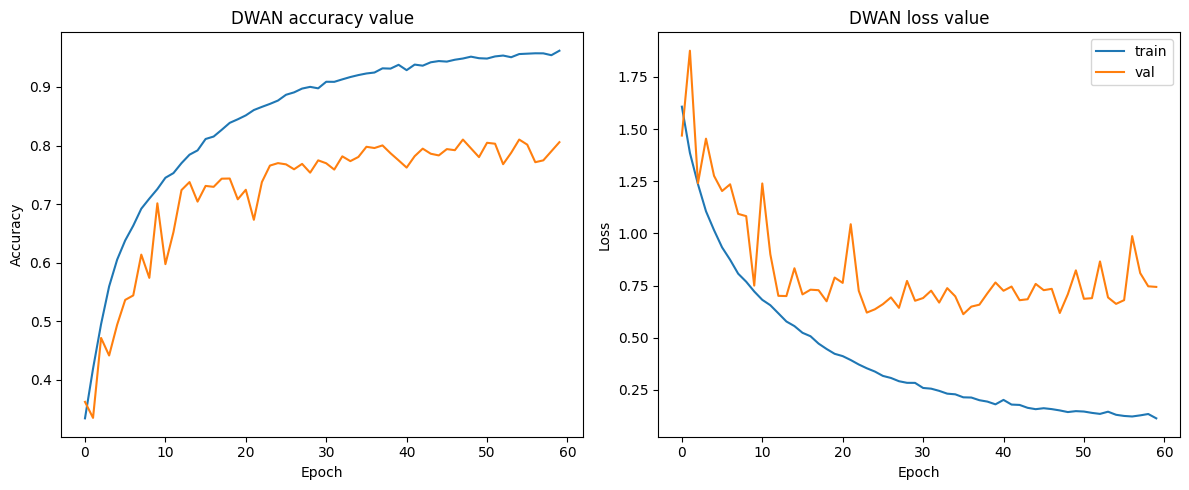

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("DWAN accuracy value")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("DWAN loss value")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# using pre-trained exsiting models to compare with the proposed model
from keras.models import Model
from keras import applications
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3

num_classes = 5
base_model = applications.resnet50.ResNet50(weights = None, include_top=False, input_shape= (224,224,3))                             
# Add a global spatial average pooling layer
out = base_model.output
out = GlobalAveragePooling2D()(out)
out = Dense(64, activation='relu')(out)
out = Dense(10, activation='relu')(out)
predictions = Dense(num_classes, activation='softmax')(out)
Rmodel = Model(inputs=base_model.input, outputs=predictions)

# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights = None, include_top=False, 
                             input_shape=(224, 224, 3))
                             
# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(64, activation='relu')(out)
out = Dense(10, activation='relu')(out)
predictions = Dense(num_classes, activation='softmax')(out)
inception_model = Model(inputs=base_inception.input, outputs=predictions)


In [ ]:
from keras.applications.mobilenet import MobileNet
base_model = MobileNet(include_top=False, weights= None , input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dense(10, activation='relu')(x)
output = Dense(1, activation='softmax')(x)
MobileNet_model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Evaluate on the val set
test_loss, test_accuracy = Inception_DWAN.evaluate(valid_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

In [15]:
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix, precision_recall_curve

In [13]:
from sklearn.metrics import classification_report
from tqdm import tqdm
import numpy as np

from sklearn.metrics import classification_report

all_true_labels = []
all_pred_labels = []

for i in tqdm(range(len(valid_generator))):
    test_batch = next(valid_generator)
    test_x, test_y = test_batch
    pred_y = Res_DWAN(test_x, training=False)
    
    all_true_labels.extend(test_y)
    all_pred_labels.extend(np.argmax(pred_y, axis=-1)) 


all_true_labels = np.array(all_true_labels).argmax(axis=1)
all_pred_labels = np.array(all_pred_labels)


report = classification_report(all_true_labels, all_pred_labels)

print(report)


100%|██████████| 119/119 [00:59<00:00,  2.01it/s]

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       917
           1       0.81      0.57      0.67       753
           2       0.67      0.82      0.74       905
           3       0.94      0.93      0.94       320
           4       0.84      0.87      0.85       903

    accuracy                           0.79      3798
   macro avg       0.82      0.80      0.81      3798
weighted avg       0.80      0.79      0.79      3798



119/119 [==============================] - 46s 384ms/step


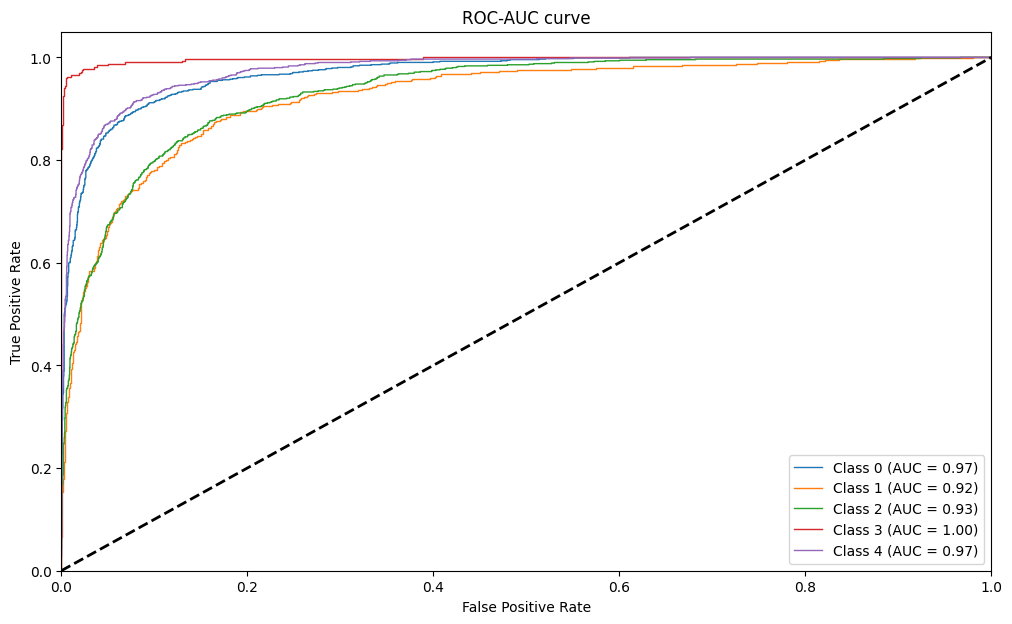

In [16]:
y_true = valid_generator.classes

predictions = Res_DWAN.predict(valid_generator, steps=len(valid_generator), verbose=1)

y_true_bin = label_binarize(y_true, classes=np.arange(7))

# False Positive Rate, True Positive Rate, AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.figure(figsize=(12, 7))

for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=1, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curve')
plt.legend(loc="lower right")
plt.show()


119/119 [==============================] - 53s 443ms/step


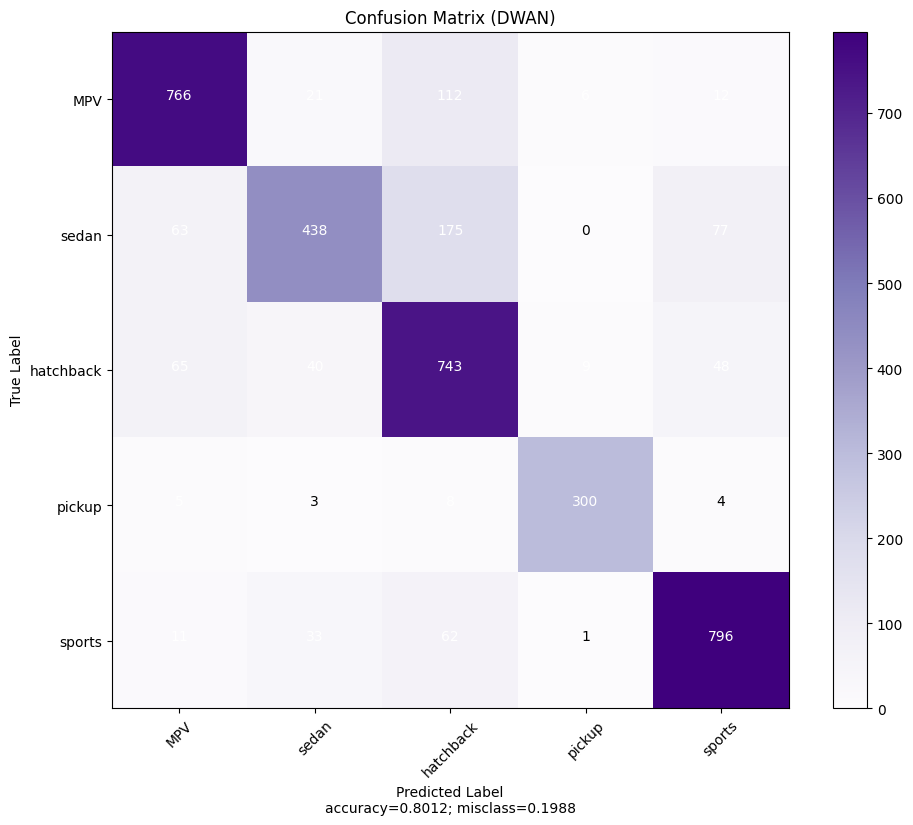

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from tqdm import tqdm

def plot_confusion_matrix(val_dataset, model, test_dataset):
    predictions = model.predict(test_dataset, steps=len(test_dataset), verbose=1)
    preds = np.argmax(predictions, axis=1)

    labels = test_dataset.classes
    class_names = list(val_dataset.class_indices.keys())

    cm = confusion_matrix(labels, preds)

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap='Purples')
    plt.colorbar()

    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45)
    plt.yticks(ticks, class_names)

    plt.title('Confusion Matrix (DWAN)')

    threshold = 4
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > threshold else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label\naccuracy={:0.4f}; misclass={:0.4f}'.format(
        accuracy, misclass
    ))

plot_confusion_matrix(valid_generator, Res_DWAN, valid_generator)

119/119 [==============================] - 50s 416ms/step


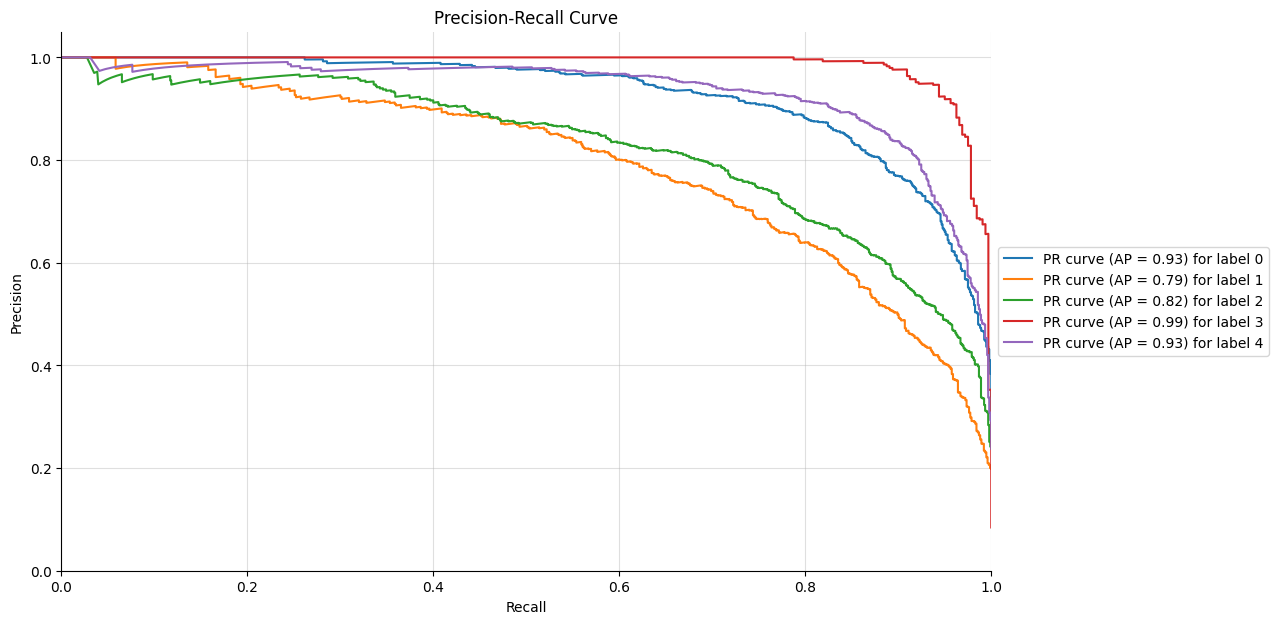

In [18]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def plot_precision_recall_curve(model, test_dataset):
    y_true = test_dataset.labels

    predictions = model.predict(test_dataset, steps=len(test_dataset), verbose=1)

    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(5):
        precision[i], recall[i], _ = precision_recall_curve(y_true == i, predictions[:, i])
        average_precision[i] = auc(recall[i], precision[i])

    fig, ax = plt.subplots(figsize=(12, 7))
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve')

    for i in range(5):
        ax.plot(recall[i], precision[i], label='PR curve (AP = %0.2f) for label %i' % (average_precision[i], i))

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_precision_recall_curve(Res_DWAN, valid_generator)

In [19]:
import pandas as pd
def sensitivity_specificity(model, test_dataset): 
    y_true = test_dataset.classes  
    predictions = model.predict(test_dataset, steps=len(test_dataset), verbose=1) 
    
    y_pred = np.argmax(predictions, axis=1) 
    cm = confusion_matrix(y_true, y_pred)  
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0]) 
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) 
    result_df = pd.DataFrame({ 'Metric': ['Sensitivity', 'Specificity'], 'Value': [sensitivity, specificity] }) 
    return result_df 

result_df = sensitivity_specificity(Res_DWAN, valid_generator) 
print(result_df)

119/119 [==============================] - 47s 393ms/step
        Metric     Value
0  Sensitivity  0.887064
1  Specificity  0.972257


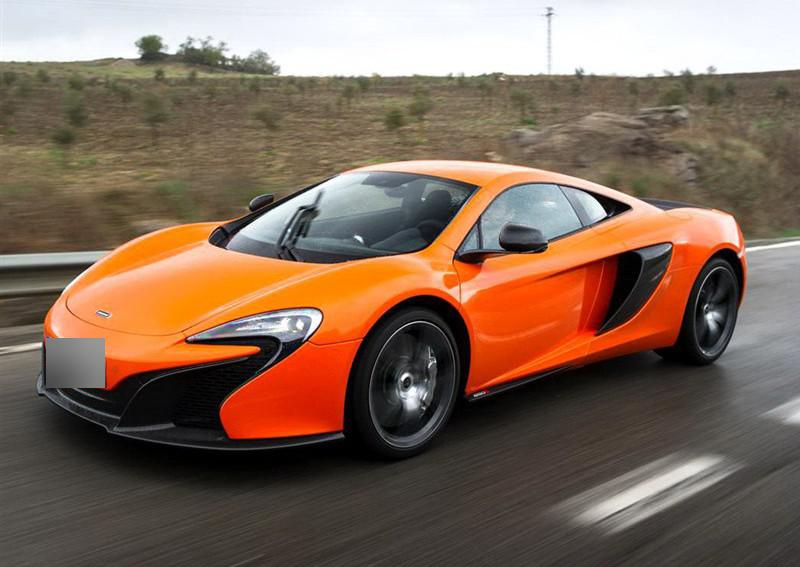

1/1 [==============================] - 0s 35ms/step


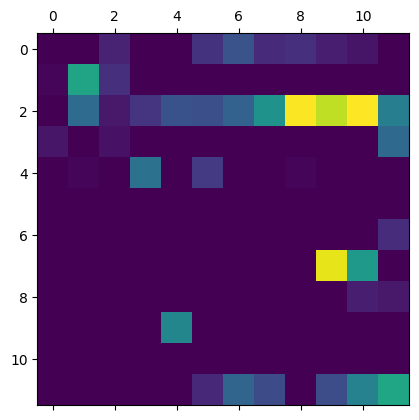

/tmp/ipykernel_13676/3256897320.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


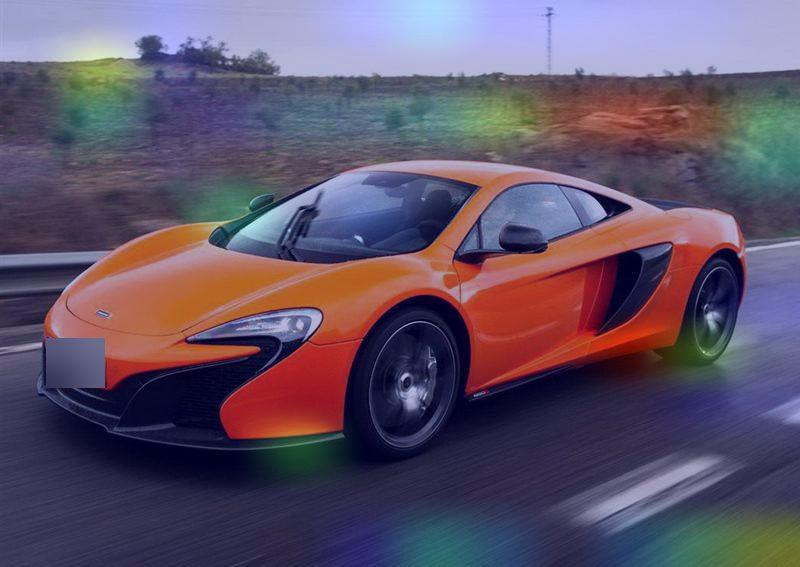

In [27]:
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing import image
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Model definition using Keras Applications
model_builder = keras.applications.xception.Xception
img_size = (224, 224)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
last_conv_layer_name = "conv2d_24"  # Update this layer name based on Xception's structure

# Path to your target image
img_path = "/home/featurize/work/Compus_cars/train/sports/00b77dc1bf69d2.jpg"

display(Image(img_path))

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return preprocess_input(array)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

img_array = get_img_array(img_path, size=img_size)

# Load the model
model = Res_DWAN

# Predict class
preds = model.predict(img_array)
# top_preds = decode_predictions(preds, top=1)[0]
# print("Predicted class:", top_preds[0][1], "with probability", top_preds[0][2])

# Generate class activation heatmap for the top predicted class
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=np.argmax(preds))

# Display heatmap
plt.matshow(heatmap)
plt.show()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    # Save and display the superimposed image
    superimposed_img.save(cam_path)
    display(Image(cam_path))

save_and_display_gradcam(img_path, heatmap)


In [ ]:
from tensorflow import keras
import cv2
import matplotlib
from keras import applications
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

list_images_sample = [
    "/home/featurize/work/Compus_cars/train/hatchback/000f2ebfe51758.jpg",
    "/home/featurize/work/Compus_cars/train/MPV/3a6b5def089e12.jpg",
    "/home/featurize/work/Compus_cars/train/pickup/00cd05192c0cd8.jpg",
    "/home/featurize/work/Compus_cars/train/sedan/0c3776ce75ed7f.jpg",
    "/home/featurize/work/Compus_cars/train/sports/00b77dc1bf69d2.jpg",
]

model_builder = keras.applications.xception.Xception
img_size = (224,224)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
imag = []
last_conv_layer_name = "spatial_attention_2"

# To Get Image into numpy array
def get_img_array(img_path, size):
    img = load_img(img_path, target_size = size) 
    array = img_to_array(img) 
    array = np.expand_dims(array, axis = 0)
    return array

# Top create heatmaps for the samples
def make_gradcam_heatmap(img_array,model, last_conv_layer_name, pred_index = None):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Storing Heatmap values into list
covid_noncovid_heatmap = []
for i in list_images_sample:
    img_array = preprocess_input(get_img_array(i, size=img_size))
    model = Inception_DWAN
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    covid_noncovid_heatmap.append(heatmap)

# To Display GradCAM output for the samples
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = load_img(img_path)
    img = img_to_array(img)
    
    # Convert heatmap to numpy array
    heatmap = np.array(heatmap)

    # Resize heatmap to match image dimensions
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Normalize resized heatmap to uint8
    heatmap_resized = (heatmap_resized - heatmap_resized.min()) / (heatmap_resized.max() - heatmap_resized.min()) * 255
    heatmap_resized = np.uint8(heatmap_resized)

    jet = matplotlib.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_resized]
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)
    superimposed_img.save(cam_path)

    imag.append(cv2.imread(img_path))
    imag.append(cv2.imread(cam_path))

for i in range(len(list_images_sample)):
    save_and_display_gradcam(list_images_sample[i], covid_noncovid_heatmap[i])

def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    num_images = len(img_matrix_list)
    fig, myaxes = plt.subplots(
        figsize=(15, 5 * (num_images // ncols)), nrows=(num_images + ncols - 1) // ncols, ncols=ncols, squeeze=False
    )
    fig.suptitle(main_title, fontsize=18)
    fig.subplots_adjust(wspace=0.1)
    fig.subplots_adjust(hspace=0.3, top=0.95)  # Adjust the top parameter to reduce the distance

    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        row = i // ncols
        col = i % ncols
        myaxes[row][col].imshow(img)
        myaxes[row][col].set_title(title, fontsize=12)
        myaxes[row][col].axis('off')

    # Remove empty subplots
    for i in range(num_images, len(myaxes.flatten())):
        row = i // ncols
        col = i % ncols
        fig.delaxes(myaxes[row][col])
    plt.show()

titles_list = [ 
"Hatchback", "Hatchback CAM",
"MPV", "MPV CAM",
"Pickup", "Pickup CAM",
"Sedan", "Sedan CAM",
"Sports", "Sports CAM",
]

plot_multiple_img(imag, titles_list, ncols=2, main_title="Vehicle Image Analysis")

In [ ]:
# 创建一个字典，用于保存每个类别的第一张图像及其索引
class_images = {}
num_classes = 5  # 类别总数
found = 0

# 从生成器中迭代，直到找到每个类别的至少一张图像
for images, labels in train_generator:
    for i, label in enumerate(labels):
        label_index = np.argmax(label)  # 获取类别索引
        if label_index not in class_images:
            class_images[label_index] = images[i]
            found += 1
        if found >= num_classes:
            break
    if found >= num_classes:
        break

# 检查是否已经收集了足够的图像
if found != num_classes:
    print("Error: Did not find enough class examples. Found only", found)
else:
    print("Successfully collected examples for each class.")


In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

# 对每个类的图片应用 LIME
for index, image in class_images.items():
    explanation = explainer.explain_instance(image, Inception_DWAN_2L.predict, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f'Class {index}')
    plt.show()


In [ ]:
import scipy.io as scio
data=scio.loadmat('./car_type.mat')

In [ ]:
type(data)

In [ ]:
data

In [ ]:
types_array = data['types']
for type_array in types_array[0]:
    print(type_array[0])